In [16]:
# Import Libraries
import numpy as np
import pandas as pd
import datetime as dt
import time
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm.autonotebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import subprocess
import optuna
import ray
from ray import tune, train
from ray.tune.search.optuna import OptunaSearch

Network

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, fc_hidden_dim, use_hn, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc_hidden_dim = fc_hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.use_hn = use_hn
        self.dropout = dropout

        # self.batchnorm = nn.BatchNorm1d(num_features=input_dim)  # Batch Normalization Layer for inputs
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Sequential(
            nn.Linear(in_features=self.hidden_dim, out_features=self.fc_hidden_dim),  # New fully connected layer
            nn.ReLU(),  # Activation function
            nn.Linear(in_features=self.fc_hidden_dim, out_features=output_dim)
        )

    def forward(self, x):
        # original_shape = x.shape
        # x = x.view(-1, original_shape[-1])
        # x = self.batchnorm(x)
        # x = x.view(original_shape)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        # Select which output to use (hn is more efficient, out holds more sequence data)
        if self.use_hn:
            hn = hn.view(-1, self.hidden_dim)
            out = self.fc(hn)
        else:
            out = out[:, -1, :]
            out = self.fc(out)
        
        return out
    

Data Processing

In [6]:
class DataProcessor:
    def __init__(self, path="data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", start='2021-03-27 15:04:00', end='2021-03-31 00:00:00', verbose=False):
        self.path = path    # Filepath of data
        self.start = start
        self.end = end
        self.verbose = verbose

    def load_data(self):
        # Import Data
        self.data = pd.read_csv(self.path)

    def clean_data(self):
        # Clean data
        self.data.fillna(method="ffill", inplace=True)  # Forward/backward fill prices
        self.data.fillna(method="bfill", inplace=True)

    def add_features(self):
        self.data['SMA'] = ta.sma(close=self.data['Close'], length=20)    # Simple Moving Average
        self.data['RSI'] = ta.rsi(close=self.data['Close'], length=14)    # Relative Strength Index
        macd = ta.macd(close=self.data['Close'], fast=12, slow=26, signal=9)  # MACD
        self.data['MACD'] = macd['MACD_12_26_9']
        #self.data['bb_upper'], self.data['bb_middle'], self.data['bb_lower'] = ta.bbands(close=self.data['Close'], length=20) # Bollinger Bands
        #self.data['VWAP'] = ta.vwap(high=self.data['High'], low=self.data['Low'], close=self.data['Close'], volume=self.data['Volume_(BTC)'])

        self.data['log_ret'] = ta.log_return(close=self.data['Close'], cumulative=False)    # Log returns
        self.data['percent_ret'] = ta.percent_return(close=self.data['Close'], cumulative=False)*10    # Percent returns

        self.data.dropna(inplace=True)  # Drop rows with NaN values
        # self.data.reset_index(drop=True, inplace=True)  # Reset the index

    def trim_data(self):
        # Convert to datetime index
        self.data['Timestamp'] = pd.to_datetime(self.data['Timestamp'], unit='s') # Convert the Timestamp column to datetime
        self.data.set_index('Timestamp', inplace=True)

        # Convert start and end to datetime
        start = pd.to_datetime(self.start)
        end = pd.to_datetime(self.end)

        # Select rows between start and end dates
        self.data = self.data.loc[start:end]

        if self.verbose:
            print(f'Data loaded --------- {self.path}')
            print(f'Using data from {start} to {end} with {len(self.data)-1} rows')

    def split_data(self):
        # Split data
        self.data.sort_values('Timestamp', inplace=True) # Sort the dataframe by timestamp
        train_val, self.test = train_test_split(self.data, test_size=0.15, shuffle=False) # Split the data
        self.train, self.val = train_test_split(train_val, test_size=0.176, shuffle=False)  # Create validation set from train

    def scale_data(self, exclude_columns): 
        for col in self.data.columns:
            if col in exclude_columns:
                continue
            if col == 'percent_ret':
                self.percent_ret_scaler = StandardScaler()
                scaler = self.percent_ret_scaler
            else:
                scaler = MinMaxScaler(feature_range=(0, 1))
            self.train[col] = scaler.fit_transform(self.train[col].values.reshape(-1, 1))
            self.val[col] = scaler.transform(self.val[col].values.reshape(-1, 1))
            self.test[col] = scaler.transform(self.test[col].values.reshape(-1, 1))

    def unscale_data(self, scaled_df):
        if self.percent_ret_scaler is None:
            raise ValueError("The 'percent_ret' column has not been scaled yet.")
        
        scaled_percent_ret = scaled_df['percent_ret'].values
        unscaled_percent_ret = self.percent_ret_scaler.inverse_transform(scaled_percent_ret.reshape(-1, 1))
        
        unscaled_df = scaled_df.copy()
        unscaled_df['percent_ret'] = unscaled_percent_ret.flatten()
        return unscaled_df

    
    def normalize_with_rolling_stats(self, window_size):
        for col in self.data.columns:
            rolling_mean = self.data[col].rolling(window=window_size).mean()
            rolling_std = self.data[col].rolling(window=window_size).std()
            self.data[col] = (self.data[col] - rolling_mean) / rolling_std
        self.data.dropna(inplace=True)
        
    def detrend_data(self, exclude_columns):
        for col in self.data.columns:
            if col in exclude_columns:
                continue
            linreg = LinearRegression()
            x = np.arange(len(self.data)).reshape(-1, 1)
            y = self.data[col].values
            linreg.fit(x, y)
            trend = linreg.predict(x)
            self.data[col] = y - trend

    def prepare_data(self, exclude_columns_detrend, exclude_columns_scale):
        self.load_data()
        self.clean_data()
        self.add_features()
        self.trim_data()
        self.split_data()
        self.detrend_data(exclude_columns=exclude_columns_detrend)
        self.scale_data(exclude_columns=exclude_columns_scale)
        
    def create_dataloaders(self, window, batch_size, exclude_input_columns):
        train_loader = TimeSeriesDataLoader(df=self.train, window=window, 
                                            batch_size=batch_size, 
                                            exclude_input_columns=exclude_input_columns).create_dataloader()
        val_loader = TimeSeriesDataLoader(df=self.val, window=window, 
                                          batch_size=batch_size, 
                                          exclude_input_columns=exclude_input_columns).create_dataloader()
        test_loader = TimeSeriesDataLoader(df=self.test, window=window, 
                                           batch_size=batch_size, 
                                           exclude_input_columns=exclude_input_columns).create_dataloader()
        return train_loader, val_loader, test_loader

class TimeSeriesDataset(Dataset):
    def __init__(self, df, window, exclude_input_columns):
        self.df = df
        self.window = window
        self.exclude_input_columns = exclude_input_columns

    def __len__(self):
        return len(self.df) - self.window

    def __getitem__(self, idx):
        drop_columns = [col for col in self.exclude_input_columns if col in self.df.columns]
        x_df = self.df.iloc[idx : idx + self.window].drop(columns=drop_columns)
        x = x_df.values
        y = self.df.iloc[idx + self.window]['percent_ret']  # Percent return at the next timestep
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
class TimeSeriesDataLoader:
    def __init__(self, df, window, batch_size, exclude_input_columns=['']):
        self.df = df
        self.window = window
        self.batch_size = batch_size
        self.exclude_input_columns = exclude_input_columns
        self.dataset = TimeSeriesDataset(df=self.df, window=self.window, exclude_input_columns=self.exclude_input_columns)

    def create_dataloader(self):
        dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False)
        return dataloader

Test data loading

In [7]:
# Preprocess data
path = 'data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
start = '2021-03-30 00:00:00'
end = '2021-03-31 00:00:00'
verbose = True

data_processor = DataProcessor(path=path, start=start, end=end, verbose=verbose)
data_processor.prepare_data(exclude_columns_detrend=['SMA', 'RSI', 'MACD', 'log_ret', 'percent_ret'],
                            exclude_columns_scale=['log_ret', 'percent_ret'])

# Create dataloaders
window = 10
batch_size = 64

train_loader, val_loader, test_loader = data_processor.create_dataloaders(window=10, 
                                                                          batch_size=32,
                                                                          exclude_input_columns=[''])

data_processor.train.head()

Data loaded --------- data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
Using data from 2021-03-30 00:00:00 to 2021-03-31 00:00:00 with 1440 rows


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,SMA,RSI,MACD,log_ret,percent_ret
Timestamp,,,,,,,,,,,,
2021-03-30 00:00:00,0.258497,0.266949,0.253401,0.273153,0.061575,0.060983,0.257939,0.254462,0.520251,0.374126,0.001223,0.012236
2021-03-30 00:01:00,0.240734,0.229228,0.201345,0.192764,0.014084,0.013929,0.221845,0.253190,0.235106,0.320573,-0.003268,-0.032627
2021-03-30 00:02:00,0.192115,0.241298,0.195447,0.246887,0.056052,0.055489,0.247135,0.253666,0.419462,0.316518,0.002201,0.022038
2021-03-30 00:03:00,0.252264,0.251316,0.242924,0.247070,0.007474,0.007397,0.239168,0.252559,0.420015,0.313214,0.000007,0.000075
2021-03-30 00:04:00,0.245555,0.248202,0.228727,0.254376,0.007140,0.007062,0.224739,0.252938,0.443036,0.315564,0.000297,0.002968


Trainer class

In [8]:
class Trainer:
    def __init__(self,
                 model,
                 device,
                 verbose=False,
                 runningInColab=False,
                 use_TPU=False,
                 use_tensorboard=False):
        
        # Model parameters
        self.model = model
        self.model_name = self.model.__class__.__name__
        self.device = device
        self.criterion = nn.MSELoss()  # Mean Squared Error Loss
        
        # Debug
        self.verbose = verbose
        self.runningInColab = runningInColab
        self.use_TPU = use_TPU
        self.use_tensorboard = use_tensorboard

    def train_model(self, train_loader, val_loader, epochs, lr, no_change_patience, overfit_patience, warmup, save_best=False):
        # Training Parameters
        self.epochs = epochs
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(self.optimizer, 'min')
        self.no_change_patience = no_change_patience
        self.overfit_patience = overfit_patience
        self.model = self.model.to(self.device)
        self.warmup = warmup

        self.train_loader = train_loader
        # self.val_loader = val_loader

        if self.verbose:
            print(f'Training --------- Model: {self.model_name}')
            
        if self.use_tensorboard:
            self.tensorboard_process = self.start_tensorboard()

        train_losses = []
        val_losses = []
        
        train_elapsed_time = 0
        best_val_loss = float('inf')  # Initialize best validation loss
        no_improvement_count = 0  # Counter for early stopping
        overfit_count = 0
        mean_loss_epoch = 0
        mean_loss_training = 0
        mean_loss_val = 0
        val_loss = 0
        elapsed_time = 0

        tqdm_epochs = tqdm(range(epochs), disable=not self.verbose, desc='Epochs')
        
        for epoch in tqdm_epochs:
            self.model.train()
            batch_losses = []
            start_time = time.time()

            for i, (x, y) in enumerate(train_loader):
                tqdm_epochs.set_description_str(desc=f"Batch [{i+1}/{len(train_loader)}]\t")
                
                x, y = x.to(self.device), y.to(self.device)

                # Forward pass
                outputs = self.model(x).squeeze()  # Remove extra dimension from model's output
                loss = self.criterion(outputs, y)

                # Backward pass and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                batch_losses.append(loss.item())
                
                postfix_str = (
                    f"Batch Loss: {loss.item():.4g} ({np.mean(batch_losses):.4g})\t"
                    f"Loss: {mean_loss_epoch:.4g} ({mean_loss_training:.4g})\t"
                    f"Val Loss: {val_loss:.4g} ({mean_loss_val:.4g})"
                )
                tqdm_epochs.set_postfix_str(postfix_str)

            elapsed_time = time.time() - start_time
            train_elapsed_time += elapsed_time
            mean_loss_epoch = np.mean(batch_losses)
            train_losses.append(mean_loss_epoch)
            mean_loss_training = np.mean(train_losses)
            
            # Validation loop
            val_loss = self.evaluate_model(val_loader)
            val_losses.append(val_loss)
            mean_loss_val = np.mean(val_losses)
            scheduler.step(val_loss)    # Learning rate scheduler step
            
            if self.use_tensorboard:
                # Log scalar values - TensorBoard
                self.writer.add_scalar('Training Loss', mean_loss_epoch, epoch)
                self.writer.add_scalar('Validation Loss', val_loss, epoch)
                
                # Log model parameters and gradients - TensorBoard
                for name, param in self.model.named_parameters():
                    self.writer.add_histogram(name, param, epoch)
                    self.writer.add_histogram(f"{name}.grad", param.grad, epoch)
            
            # Early stopping logic for no improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_count = 0
                if save_best:
                    self.save_model(model_path=f"saved_models/{self.model_name}.pth")
            else:
                no_improvement_count += 1

            # Early stopping logic for overfitting
            if mean_loss_val > mean_loss_epoch:
                overfit_count += 1
            else:
                overfit_count = 0  # Reset if not overfitting
            
            if epoch >= self.warmup:
                if no_improvement_count >= no_change_patience or overfit_count >= overfit_patience:
                    reason = "no improvement in validation loss" if no_improvement_count >= no_change_patience else "overfitting"
                    print(f"Early stopping due to {reason}.")
                    break
            
        # Save learning data
        self.train_losses = train_losses
        self.val_losses = val_losses
        if self.verbose:
            print(f'Total Train Time: {train_elapsed_time:.2f}s, Avg Epoch: {train_elapsed_time/epochs:.2f}s')
        
        # Close TensorBoard writer
        if self.use_tensorboard:
            self.writer.close()

    def evaluate_model(self, loader):
        self.model.eval()  # Set model to evaluation mode
        start_time = time.time()

        # if self.verbose:
            # print(f'Evaluating {set_name} Set --------- Model: {self.model_name}')
        
        # t = tqdm(loader, disable=not self.verbose)    # Progress bar

        total_loss = 0.0
        with torch.no_grad():
            for i, (x, y) in enumerate(loader):
                x, y = x.to(self.device), y.to(self.device)

                outputs = self.model(x).squeeze()  # Forward pass

                loss = self.criterion(outputs, y)  # Compute loss

                total_loss += loss.item()
                
                # if self.verbose:
                #     t.set_description(f'[{i+1}/{len(loader)}] Loss: {total_loss/(i+1):.4f}')
            
        elapsed_time = time.time() - start_time

        mean_loss = total_loss / len(loader)

        # if self.verbose:
        #     t.set_description(f'Loss: {mean_loss:.4f}, Time Elapsed: {elapsed_time:.2f}s')

        return mean_loss

    def predict(self, loader, output_as_df=False):
        self.model.eval()  # Set model to evaluation mode
        start_time = time.time()

        if self.verbose:
            print(f'Predicting --------- Model: {self.model_name}')
        
        t = tqdm(loader, disable=not self.verbose, desc='Predicting')   # Progress bar

        predictions = torch.tensor([], device=self.device)
        timestamps = []
        with torch.no_grad():
            for i, (x, _) in enumerate(t):
                x = x.to(self.device)
                outputs = self.model(x).squeeze()  # Forward pass

                predictions = torch.cat((predictions, outputs), dim=0)
        elapsed_time = time.time() - start_time

        if self.verbose:
            print(f'Time Elapsed: {elapsed_time:.2f}s')
        
        if output_as_df:
            shifted_timestamps = loader.dataset.df.index[loader.dataset.window: loader.dataset.window + len(predictions)]
            return pd.DataFrame({'Timestamp': shifted_timestamps, 'percent_ret': predictions.cpu().numpy()}).set_index('Timestamp')

        return predictions

    def plot_data(self, actual, predicted, set_name, loss, column_to_plot, xlim=None, ylim=None):
        
        # Ensure column_to_plot is a list
        if not isinstance(column_to_plot, list):
            column_to_plot = [column_to_plot]
        
        num_subplots = len(column_to_plot)
        
        fig, axes = plt.subplots(nrows=num_subplots, ncols=1, figsize=(10, 3*num_subplots))
        
        if num_subplots == 1:
            axes = [axes]  # Make it iterable for consistency
        
        for idx, col in enumerate(column_to_plot):
            ax = axes[idx]
            
            if col == 'Close':
                plot_data = actual['Close'].shift(1) * (1 + predicted['percent_ret'])
                actual_data = actual[['Close']]
            elif col == 'percent_ret':
                plot_data = predicted
                actual_data = actual[['percent_ret']]
            else:
                raise ValueError(f"Unsupported column: {col}")
            
            ax.plot(actual_data.index, actual_data, label='Actual', color='green', lw=1)
            ax.plot(plot_data.index, plot_data, label='Predicted', color='red', lw=1)
            
            if xlim is not None and len(xlim) > 0:  # Set x-axis limit if provided
                xlim = pd.to_datetime(xlim)
                ax.set_xlim(xlim)
            if ylim:  # Set y-axis limit if provided
                ax.set_ylim(ylim)
            
            ax.set_title(f'{col} Over Time ({set_name}, MSE={loss:.5g})', fontsize=16)
            ax.set_xlabel('Time', fontsize=14)
            ax.set_ylabel(f'Value ({col})', fontsize=14)
            ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_learning_curves(self, train_losses, val_losses):
        """
        Plot the learning curves for training and validation losses.
        
        Parameters:
        - train_losses: List of training loss values
        - val_losses: List of validation loss values
        """
        epochs = range(1, len(train_losses) + 1)
        
        # Plotting the learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Training Loss', marker='o')
        plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
        
        plt.title('Learning Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.show()
        
    def start_tensorboard(self):
        log_dir = 'tensorboard/experiment_1'
        tensorboard_cmd = f"tensorboard --logdir={log_dir}"
        self.writer = SummaryWriter(log_dir)
        process = subprocess.Popen(tensorboard_cmd.split())
        return process

    def stop_tensorboard(self):
        if self.tensorboard_process:
            self.tensorboard_process.terminate()
            
    def save_model(self, model_path):
        torch.save(self.model.state_dict(), model_path)
    
    def load_model(self, model_path):
        """
        Load a pre-trained model from the given path.
        
        Parameters:
        - model_path (str): The path to the saved model's state dictionary.
        """
        self.model.load_state_dict(torch.load(model_path))
        if self.verbose:
            print(f'Model loaded --------- {model_path}')

Environment Handler

In [9]:
def google_colab_handler(use_TPU, verbose=False):
    try:
        from google.colab import drive
        runningInColab = True
    except:
        runningInColab = False

    # runningInColab = 'google.colab' in str(get_ipython())

    if runningInColab:
        if verbose:
            print('Running in Google Colab')
        path = '/content/drive/MyDrive/Google Colab/time-series-project/'
        if use_TPU:
            import torch_xla
            import torch_xla.core.xla_model as xm
            import torch_xla.debug.metrics as met
            import torch_xla.distributed.parallel_loader as pl

            device = xm.xla_device()
            if xm.xla_device().type == 'xla':
                if verbose:
                    print('TPU is available')
            # Initialize the TPU cores
            xm.rendezvous('init')
        else:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else CPU
    else:
        path = 'working/data/'
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else CPU
        if device == 'cuda':
            torch.cuda.empty_cache()
    if verbose:
        print(f"Using Device: {device}")

    return runningInColab, use_TPU, path, device

Train model

Using Device: cuda
Data loaded --------- data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
Using data from 2021-03-25 00:00:00 to 2021-03-31 00:00:00 with 8640 rows
Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [64, 1]                   --
├─LSTM: 1-1                              [64, 10, 256]             801,792
├─Sequential: 1-2                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 256]                 65,792
│    └─ReLU: 2-2                         [64, 256]                 --
│    └─Linear: 2-3                       [64, 1]                   257
Total params: 867,841
Trainable params: 867,841
Non-trainable params: 0
Total mult-adds (M): 517.37
Input size (MB): 0.03
Forward/backward pass size (MB): 1.44
Params size (MB): 3.47
Estimated Total Size (MB): 4.94
Training --------- Model: LSTM


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Early stopping due to no improvement in validation loss.
Total Train Time: 179.09s, Avg Epoch: 3.58s


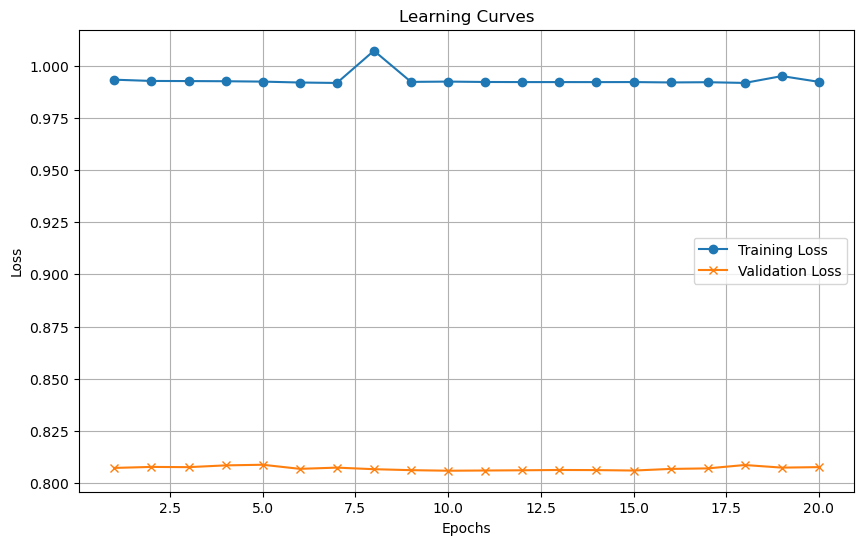

In [10]:
runningInColab, use_TPU, path, device = google_colab_handler(use_TPU=False, verbose=True)

# Preprocess data
path = 'data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
start = '2021-03-25 00:00:00'
end = '2021-03-31 00:00:00'
verbose = True
data_processor = DataProcessor(path=path, start=start, end=end, verbose=verbose)
data_processor.prepare_data(exclude_columns_detrend=['SMA', 'RSI', 'MACD', 'log_ret', 'percent_ret'],
                            exclude_columns_scale=['log_ret'])

# data_processor.data.head()

# Create dataloaders
train_loader, val_loader, test_loader = data_processor.create_dataloaders(window=10, 
                                                                          batch_size=64,
                                                                          exclude_input_columns=['percent_ret'])

# Input dimension
sample_batch = next(iter(train_loader))
sample_x, _ = sample_batch
input_dim = sample_x.shape[2] 

# Initialize model
model = LSTM(input_dim=input_dim, 
             hidden_dim=256, 
             output_dim=1, 
             num_layers=2, 
             fc_hidden_dim=256,
             use_hn=False, 
             dropout=0.5)

# Print model summary
print(summary(model, input_data=sample_x))

# Train
trainer = Trainer(model=model,
                  device=device,
                  verbose=True,
                  runningInColab=runningInColab,
                  use_TPU=use_TPU,
                  use_tensorboard=False)

trainer.train_model(train_loader=train_loader,
                    val_loader=val_loader,
                    epochs=50,
                    lr=0.001,
                    no_change_patience=10,
                    overfit_patience=100,
                    warmup=10,
                    save_best=True)

trainer.plot_learning_curves(trainer.train_losses, trainer.val_losses)

In [11]:
if trainer.use_tensorboard:
    trainer.stop_tensorboard()

Predict and plot

Model loaded --------- saved_models/LSTM.pth
Predicting --------- Model: LSTM


Predicting:   0%|          | 0/21 [00:00<?, ?it/s]

Time Elapsed: 1.61s


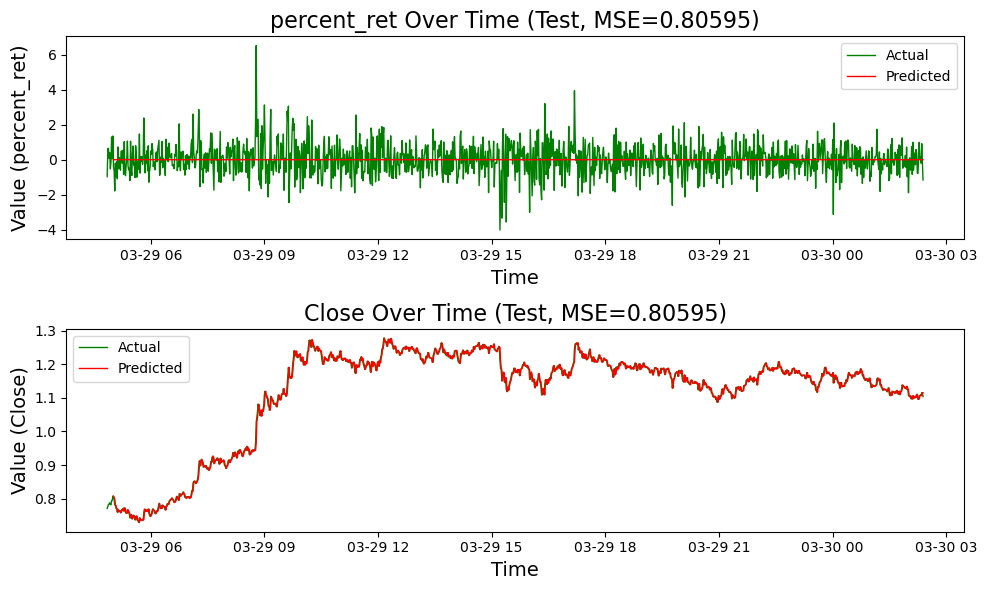

In [12]:
trainer = Trainer(model=model,
                  device=device,
                  verbose=True,
                  runningInColab=runningInColab,
                  use_TPU=use_TPU,
                  use_tensorboard=False)

trainer.load_model(model_path='saved_models/LSTM.pth')

val_actual = data_processor.val
val_predicted = trainer.predict(loader=val_loader, output_as_df=True)
val_predicted = data_processor.unscale_data(val_predicted)
val_loss = trainer.evaluate_model(loader=val_loader)
# print(val_predicted.tail())

trainer.plot_data(actual=val_actual,
                  predicted=val_predicted,
                  set_name='Test',
                  column_to_plot=['percent_ret', 'Close'],
                  loss=val_loss,
                  xlim=[])#['2021-03-30 22:00:00', '2021-03-31 00:00:00'])

Tuning with RayTune

In [17]:
original_cwd = os.getcwd() 

def objective(config):
    runningInColab, use_TPU, path, device = google_colab_handler(use_TPU=False)

    # Preprocess data
    path = 'data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
    file_path = os.path.join(original_cwd, path)
    start = '2021-03-30 00:00:00'
    end = '2021-03-31 00:00:00'
    verbose = False
    data_processor = DataProcessor(path=file_path, start=start, end=end, verbose=verbose)
    data_processor.prepare_data(exclude_columns_detrend=['SMA', 'RSI', 'MACD', 'log_ret', 'percent_ret'],
                                exclude_columns_scale=['log_ret'])


    # Create dataloaders
    train_loader, val_loader, test_loader = data_processor.create_dataloaders(window=config['window'], 
                                                                            batch_size=config['batch_size'],
                                                                            exclude_input_columns=['percent_ret'])

    # Input dimension
    sample_batch = next(iter(train_loader))
    sample_x, _ = sample_batch
    input_dim = sample_x.shape[2] 

    # Initialize model
    model = LSTM(input_dim=input_dim, 
                hidden_dim=config['hidden_dim'], 
                output_dim=1, 
                num_layers=config['num_layers'], 
                fc_hidden_dim=config['fc_hidden_dim'],
                use_hn=False, 
                dropout=config['dropout'])

    # Train
    trainer = Trainer(model=model,
                    device=device,
                    verbose=False,
                    runningInColab=runningInColab,
                    use_TPU=use_TPU,
                    use_tensorboard=False)

    trainer.train_model(train_loader=train_loader,
                        val_loader=val_loader,
                        epochs=30,
                        lr=config['lr'],
                        no_change_patience=config['no_change_patience'],
                        overfit_patience=100,
                        warmup=config['warmup'],
                        save_best=False)

    # trainer.plot_learning_curves(trainer.train_losses, trainer.val_losses)
    
    last_val_loss = trainer.val_losses[-1]
    train.report({'val_loss': last_val_loss})

In [1]:
search_space = {
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([32, 64, 128]),
    "window": tune.choice([5, 10, 20]),
    "hidden_dim": tune.choice([128, 256, 512]),
    "fc_hidden_dim": tune.choice([128, 256, 512]),
    "dropout": tune.uniform(0.1, 0.5),
    "warmup": tune.choice([0, 50, 100]),
    "no_change_patience": tune.choice([5, 10, 15]),
    "overfit_patience": tune.choice([5, 10, 15]),
    "num_layers": tune.choice([1, 2, 3])
}

algo = OptunaSearch()

ray.init(dashboard_port=8889, ignore_reinit_error=True, include_dashboard=True)

analysis = tune.run(
    objective,
    config=search_space,
    search_alg=algo,
    metric="val_loss",
    mode="min",
    resume="AUTO",
    local_dir="/ray_results"
)

print("Best config is:", analysis.get_best_config(metric="val_loss", mode="min"))


NameError: name 'tune' is not defined